In [24]:
import math
import pandas as pd
import numpy as np
import json

from pykalman import KalmanFilter

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

pd.options.mode.chained_assignment = None


# Data Analysis

### Data extraction and cleaning
The sample data includes order book and trades data of the pair IOTA/BTC from Binance. For convience, I apply a price multiplier as the price of IOTA/BTC is rather small. There are 100 levels of bids/asks in the order book data. Data extraction and cleaning is performed to read the csv files and get best_bid, best_ask and mid_price.

In [25]:
PRICE_ADJ_MULT = 100_000_000

def best_ask(asks):
    return np.array(json.loads(asks))[:,0].min()

def best_bid(bids):
    return np.array(json.loads(bids))[:,0].max()


In [26]:
# Data Extraction and Cleaning
df_trades=pd.read_csv('./trades.csv')
df_trades=df_trades[['timestamp', 'id', 'price', 'side', 'amount']]
df_trades['price']=df_trades.price*PRICE_ADJ_MULT

df_orders=pd.read_csv('./binance_iotabtc_orderbooks/2020-07-17.csv')
df_orders['best_ask']=df_orders['asks'].apply(best_ask)*PRICE_ADJ_MULT
df_orders['best_bid']=df_orders['bids'].apply(best_bid)*PRICE_ADJ_MULT
df_orders['mid_price']=(df_orders['best_ask']+df_orders['best_bid'])/2

display(df_orders.head(5))
display(df_trades.head(5))


,lastUpdated,asks,bids,best_ask,best_bid,mid_price
0,2020-07-17 00:00:23.225,"[[2.644e-05, 5243], [2.645e-05, 4216], [2.646e...","[[2.639e-05, 4216], [2.638e-05, 7000], [2.637e...",2644.0,2639.0,2641.5
1,2020-07-17 00:00:30.293,"[[2.645e-05, 4216], [2.646e-05, 763], [2.647e-...","[[2.638e-05, 4989], [2.637e-05, 2427], [2.6360...",2645.0,2638.0,2641.5
2,2020-07-17 00:00:30.429,"[[2.645e-05, 4216], [2.646e-05, 763], [2.647e-...","[[2.639e-05, 4216], [2.638e-05, 4989], [2.637e...",2645.0,2639.0,2642.0
3,2020-07-17 00:01:04.450,"[[2.644e-05, 11], [2.646e-05, 4978], [2.647e-0...","[[2.639e-05, 4216], [2.638e-05, 6689], [2.637e...",2644.0,2639.0,2641.5
4,2020-07-17 00:01:10.753,"[[2.643e-05, 7], [2.645e-05, 3982], [2.646e-05...","[[2.639e-05, 4216], [2.638e-05, 6689], [2.637e...",2643.0,2639.0,2641.0


,timestamp,id,price,side,amount
0,2020-07-17 00:01:10.647,19088200,2643.0,buy,4.0
1,2020-07-17 00:01:26.820,19088201,2640.0,sell,58.0
2,2020-07-17 00:01:26.825,19088202,2640.0,sell,25.0
3,2020-07-17 00:01:26.841,19088203,2640.0,sell,235.0
4,2020-07-17 00:01:26.842,19088204,2640.0,sell,36.0


### Data Visualization

In this section, I use Plotly interactive graph to visualize the order book and trade data for a given time period. 

In [28]:
# Data selection
df=df_trades.head(1500)
df['VWAP'] = (df['price'] * df['amount']).rolling(100).mean()/df['amount'].rolling(100).mean()
df_buy=df.query("side=='buy'")
df_sell=df.query("side=='sell'")
df1=df_orders.head(3000)

# Visualization
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df_buy['timestamp'], y=df_buy['price'],mode="markers",name='trade buy'),row=1, col=1)
fig.add_trace(go.Scatter(x=df_sell['timestamp'], y=df_sell['price'],mode="markers",name='trade sell'),row=1, col=1)
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['VWAP'],name='VWAP',line_shape='hv'),row=1, col=1)

fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['best_bid'],name='best bid',line_shape='hv'),row=1, col=1)
fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['best_ask'],name='best ask',line_shape='hv'),row=1, col=1)
fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['mid_price'],name='mid price',line_shape='hv'),row=1, col=1)
# fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['Q1_ask'],name='Q1_ask',line_shape='hv'),row=1, col=1)
# fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['Q1_bid'],name='Q1_bid',line_shape='hv'),row=1, col=1)


# Market Making Agent

A MarketMaker class is inplemented in market_maker.py. The class has two main functions.
### Update fair price (Users can choose from 4 methods): 
1. MidPrice: Update fair value based on the market mid price
2. KalmanFilter: The observed mid-prices are dynamic and noisy. So we can apply a Kalman filter for better fair value estimation.
3. VWAP: Calculate fair value based on trade data using VWAP
4. RefOverride: Override fair price using reference price. Reference prices may come from other exchanges with better liquidity

### Generate quotes 
Using Avellaneda & Stoikov’s strategy to find the optimal bid/ask spreads and taking inventory risk into consideration. 

## Kalman Filter Fair Price Estimation

While the mid-price can be used as an estimation of fair price, we have observed the mid-prices are noisy, dynamic and unstable. The Kalman filter is an algorithm used for estimating the state of a dynamic system from a series of incomplete and noisy measurements.

The goal is to find the mean price of the price series. So the mean price m(t) is the hidden variable here, and the mid-price y(t) is the observable variable. 

The measurement equation is:
y (1) = m(t) + e(t)

with the same state transition equation:
m(t) =m(t-1) + w(t - 1).

The state update equation is:
m(t|t) = m(t|t - 1) + K(t) (y (t) - m(t|t - 1))

The variance of the forecast error is:
Q(t) = Var(m(1)) + V.

The Kalman gain is:
K(+) = R(+ | +-1)/(R(t |+ -1) + V)

and the state variance update is:
R(t It) = (1 - K(t))R(t It - 1)

Below is a simple implementation of applying the Kalman Filter to find the fair price. We can see the Kalman Filter Prices is smoother and less noisy than the mid prices from the order book:
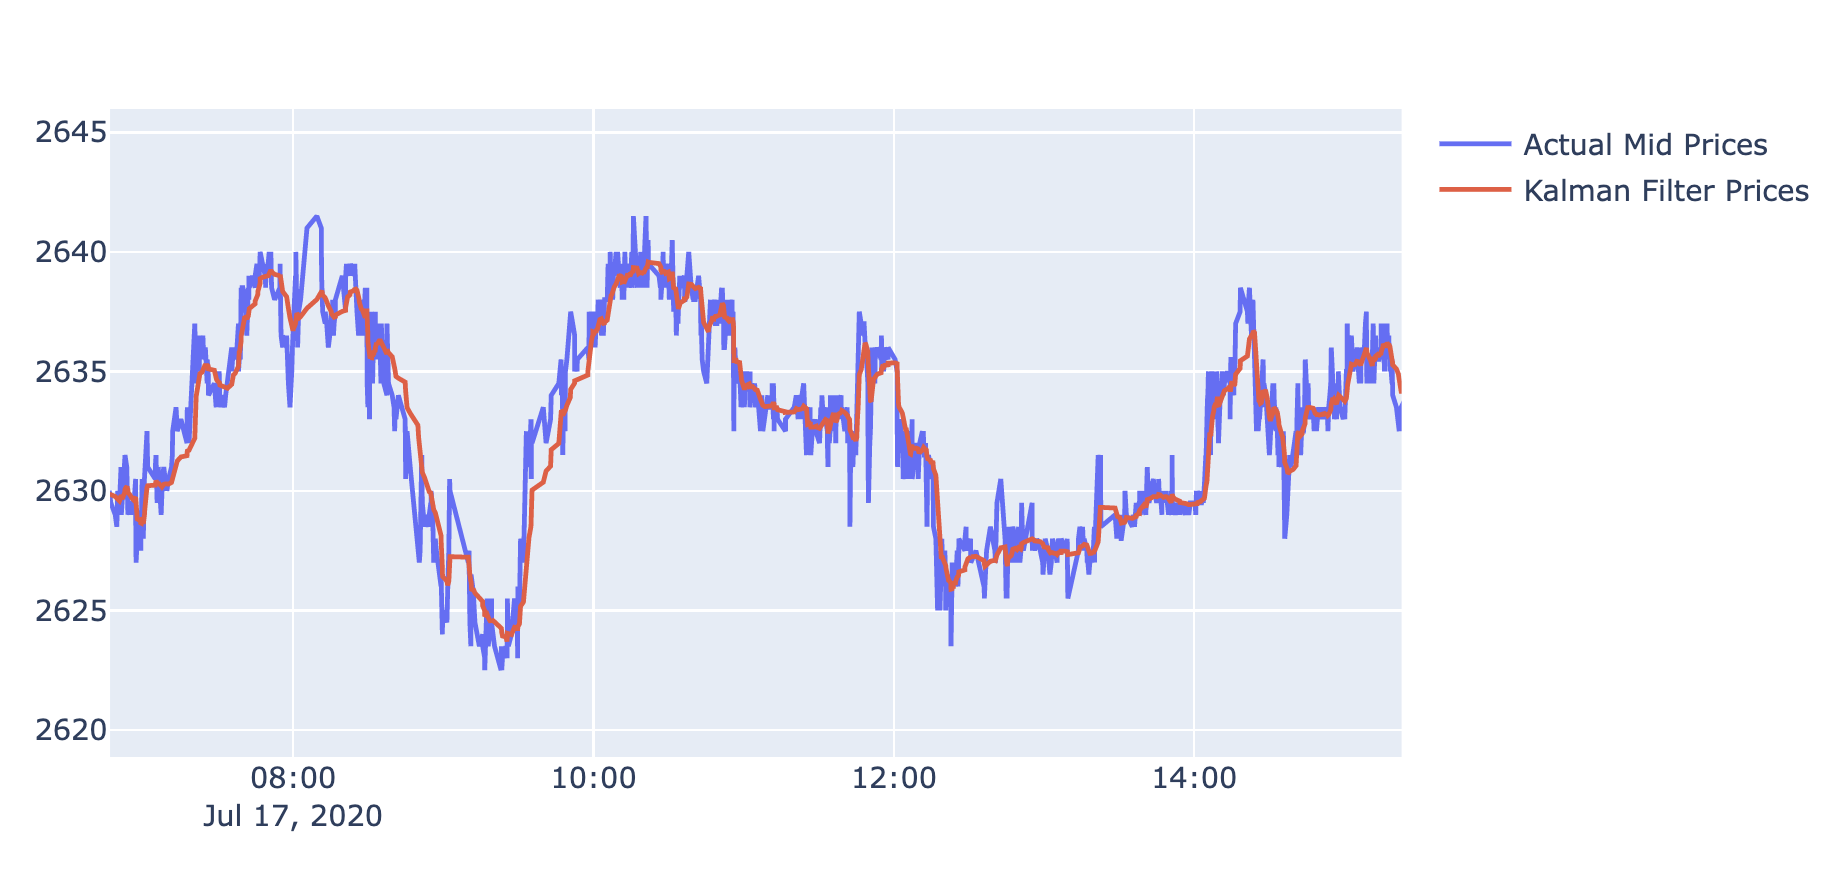


In [23]:
# Apply KalmanFilter to estimate the fair value from Mid Prices
# Load and preprocess the data
data = df_orders[['lastUpdated','mid_price']]
prices = data['mid_price'].values.reshape(-1, 1)

# Initialize the Kalman filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=prices[0, 0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

# Run the Kalman filter to obtain filtered estimates
filtered_state_means, filtered_state_covariances = kf.filter(prices)

# Extract the predicted prices from the filtered estimates
predicted_prices = filtered_state_means.flatten()

# Assess the performance of the predictions
mse = np.mean((prices.flatten() - predicted_prices) ** 2)
print("Mean Squared Error (MSE):", mse)

# Plot the actual prices and predicted prices
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data['lastUpdated'], y=prices.flatten(),mode="lines",name='Actual Mid Prices'),row=1, col=1)
fig.add_trace(go.Scatter(x=data['lastUpdated'], y=predicted_prices,mode="lines",name='Kalman Filter Prices'),row=1, col=1)
# plt.figure(figsize=(12, 6))
# plt.plot(data['lastUpdated'], prices.flatten(), label='Actual Prices')
# plt.plot(data['lastUpdated'], predicted_prices, label='Predicted Prices')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('IOTA/BTC Price Prediction using Kalman Filter')
# plt.legend()
# plt.show()

Mean Squared Error (MSE): 1.7290305904465384


# Quoting

A simple symmetric quoting algo and Avellaneda & Stoikov’s algo has been implemented in the MarketMaker class. 

For the simple symmetric quoting algo. The spreads can be provided externally from traders or from another algo. If not provided, the spreads will be decide automatically according to price vol. More volatile prices will lead to wider spreads. Below graph shows the generated quotes (Q1_ask, Q1_bid) vs the existing quotes (best bid, best ask).

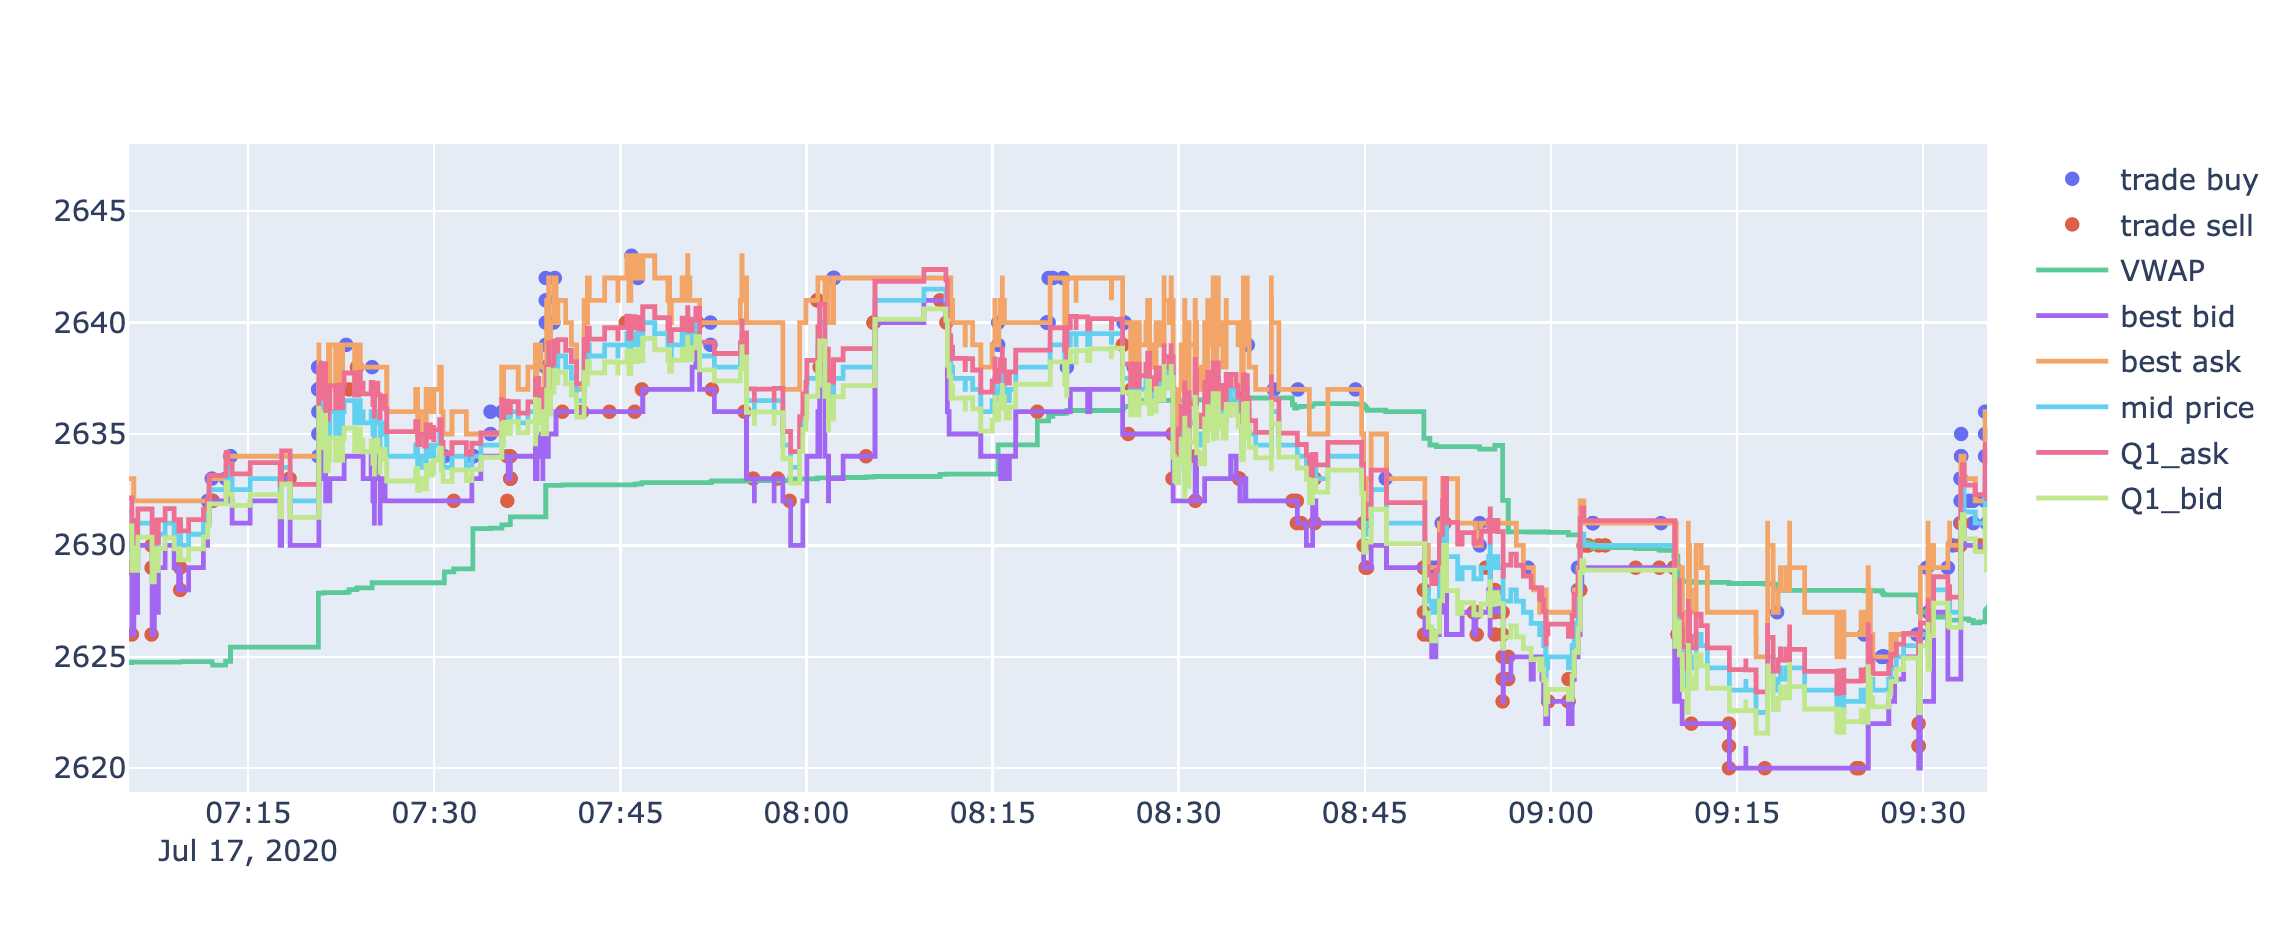

In [33]:
# Demonstration of tight quotes generted from the simple symmetric quoting algo
lk = 50
df_orders['Q1_ask']=df_orders.mid_price+0.5*df_orders.mid_price.rolling(lk).std() #p=0.6
df_orders['Q1_bid']=df_orders.mid_price-0.5*df_orders.mid_price.rolling(lk).std()

# Data selection
df=df_trades.head(1500)
df['VWAP'] = (df['price'] * df['amount']).rolling(100).mean()/df['amount'].rolling(100).mean()
df_buy=df.query("side=='buy'")
df_sell=df.query("side=='sell'")
df1=df_orders.head(3000)

# Visualization. An interactive graph.
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df_buy['timestamp'], y=df_buy['price'],mode="markers",name='trade buy'),row=1, col=1)
fig.add_trace(go.Scatter(x=df_sell['timestamp'], y=df_sell['price'],mode="markers",name='trade sell'),row=1, col=1)
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['VWAP'],name='VWAP',line_shape='hv'),row=1, col=1)

fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['best_bid'],name='best bid',line_shape='hv'),row=1, col=1)
fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['best_ask'],name='best ask',line_shape='hv'),row=1, col=1)
fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['mid_price'],name='mid price',line_shape='hv'),row=1, col=1)
fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['Q1_ask'],name='Q1_ask',line_shape='hv'),row=1, col=1)
fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['Q1_bid'],name='Q1_bid',line_shape='hv'),row=1, col=1)


### Avellaneda and Stoikov’s strategy

In this section, we highlight the Avellaneda & Stoikov’s strategy to deal with inventory risk and find the optimal bid and ask spreads. The function has been implemented in the MarketMaker class. Backtesting hasn't been done and parameters such as risk aversion parameter and order book liquidity parameter need to be tuned and decided separately

Reservation price: \
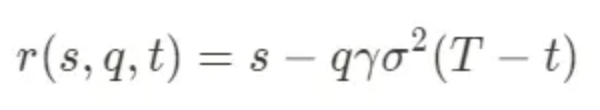

Optimal bid & ask spread: \
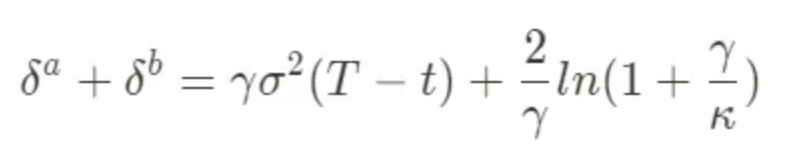


Where,

s = current market fair price \
q = quantity of assets in inventory of base asset (could be positive/negative for long/short positions) \
σ = market volatility \
T = closing time \
t = current time \
δa, δb = bid/ask spread, symmetrical → δa=δb \
γ = inventory risk aversion parameter \
κ = order book liquidity parameter \

In [ ]:
def calculate_fair_value(order_book, trade_data):
    # Calculate the weighted average price of recent trades
    trade_prices = [trade['price'] for trade in trade_data]
    trade_volumes = [trade['volume'] for trade in trade_data]
    total_volume = sum(trade_volumes)
    
    weighted_average_price = sum(price * volume for price, volume in zip(trade_prices, trade_volumes)) / total_volume
    
    # Calculate the bid-ask midpoint from the order book
    best_bid = order_book['bids'][0][0] if order_book['bids'] else None
    best_ask = order_book['asks'][0][0] if order_book['asks'] else None
    
    bid_ask_midpoint = (best_bid + best_ask) / 2 if best_bid and best_ask else None
    
    # Determine the fair value based on available data
    if weighted_average_price and bid_ask_midpoint:
        fair_value = (weighted_average_price + bid_ask_midpoint) / 2
    elif weighted_average_price:
        fair_value = weighted_average_price
    elif bid_ask_midpoint:
        fair_value = bid_ask_midpoint
    else:
        fair_value = None
    
    return fair_value

In [161]:
# Data Extraction and Cleaning
    # Load trade data over the same period
df_trades = pd.read_csv('./trades.csv')
df_trades = df_trades[['timestamp', 'id', 'price', 'side', 'amount']]
df_trades['price'] = df_trades.price*PRICE_ADJ_MULT
# Load order book data over a period of time
df_order = pd.read_csv('./binance_iotabtc_orderbooks/2020-07-17.csv')
df_order['best_ask'] = df_order['asks'].apply(best_ask)*PRICE_ADJ_MULT
df_order['best_bid'] = df_order['bids'].apply(best_bid)*PRICE_ADJ_MULT
df_order['mid_price'] = (df_order['best_ask']-df_order['best_bid'])/2

In [29]:

# df['VWAP'] = (df['price'] * df['amount']).rolling(100).mean()/df['amount'].rolling(100).mean()


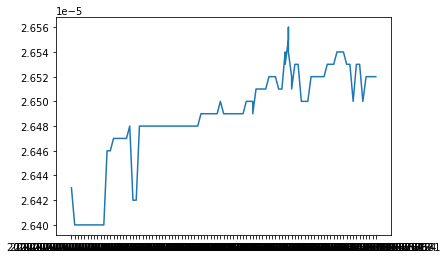

In [41]:
import matplotlib.pyplot as plt

df=df_trades.head(100)
# Plot the DataFrame
plt.plot(df['timestamp'], df['price'])

plt.show()

# Reference
https://blog.hummingbot.org/2021-04-avellaneda-stoikov-market-making-strategy/
